In [2]:
import os

os.chdir("./utils")

%pwd

'c:\\Users\\P52s\\Documents\\Obsidian\\Semestre 1 IDSCC5\\5eme année\\Data mining\\TPs\\Dev1_ANN_for_churn_modeling\\utils'

In [3]:
import pandas as pd
from decision_tree_functions import decision_tree_algorithm, calculate_accuracy, make_predictions, predict_example
from helper_functions import create_plot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
os.chdir("../../data")

%pwd

'c:\\Users\\P52s\\Documents\\Obsidian\\Semestre 1 IDSCC5\\5eme année\\Data mining\\TPs\\data'

## 1. Importation et preparation des données : 

In [26]:
df = pd.read_csv("Churn_Modelling.csv")

In [27]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [28]:
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

In [30]:
df = pd.get_dummies(df, columns=['Geography'], dtype =int)

In [31]:
cols_to_move = df.filter(like='Geography').columns.tolist()
df = df[cols_to_move + [col for col in df if col not in cols_to_move]]

In [32]:
df.head()

,Geography_France,Geography_Germany,Geography_Spain,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,0,0,619,0,42,2,0.00,1,1,1,101348.88,1
1,0,0,1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,1,0,0,502,0,42,8,159660.80,3,1,0,113931.57,1
3,1,0,0,699,0,39,1,0.00,2,0,0,93826.63,0
4,0,0,1,850,0,43,2,125510.82,1,1,1,79084.10,0


## 2. Visualisation des données : 

### Distribution du target :  

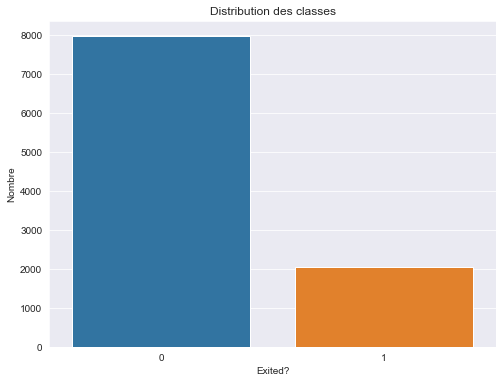

In [33]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Exited', data=df)
plt.title('Distribution des classes')
plt.xlabel('Exited?')
plt.ylabel('Nombre')
plt.show()

On constate que la classe "1" est minoritaire, donc on doit faire du upsampling 

In [34]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_upsampled, y_upsampled = oversample.fit_resample(df.drop('Exited', axis=1), df['Exited'])
X_upsampled_df = pd.DataFrame(X_upsampled, columns=df.drop('Exited', axis=1).columns)
y_upsampled_df = pd.Series(y_upsampled, name='Exited')

df = pd.concat([X_upsampled_df, y_upsampled_df], axis=1)


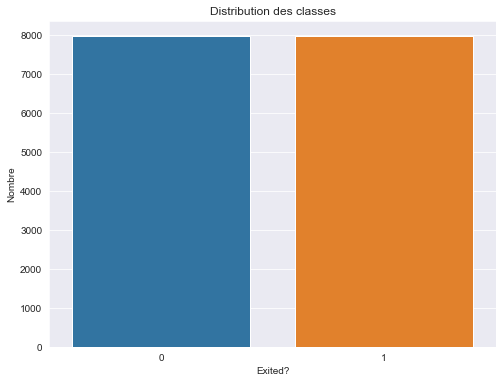

In [35]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Exited', data=df)
plt.title('Distribution des classes')
plt.xlabel('Exited?')
plt.ylabel('Nombre')
plt.show()

### Variable Continu : 

Distribution du salaire en selon la classe 

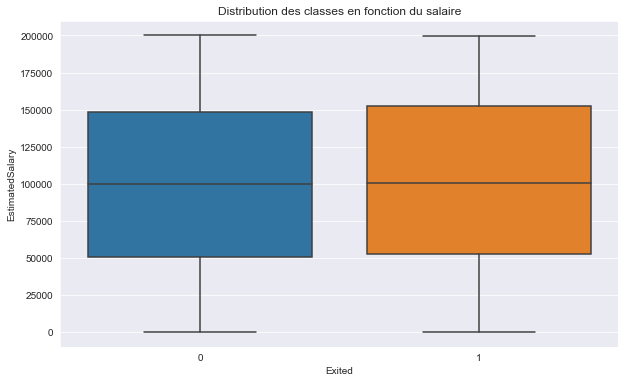

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='EstimatedSalary', data=df)
plt.title('Distribution des classes en fonction du salaire')
plt.show()

Distribution du salaire : 

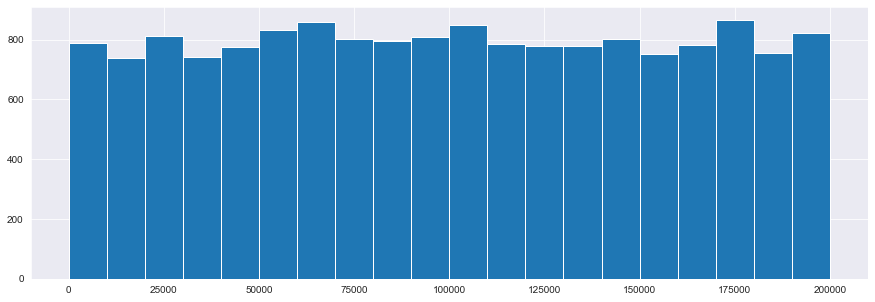

In [37]:
df["EstimatedSalary"].hist(bins=20, figsize=(15,5))
plt.show()

Distribution de "Balance" : 

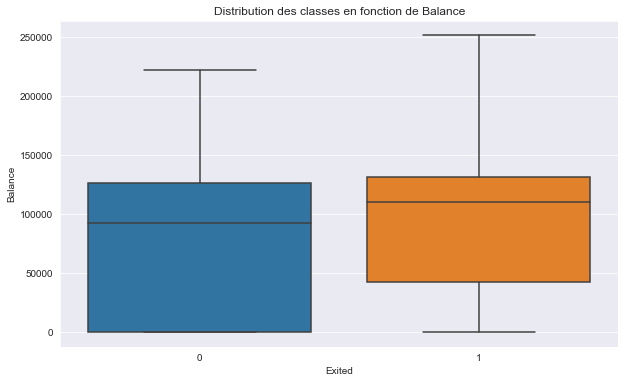

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title('Distribution des classes en fonction de Balance')
plt.show()

Voyons la distribution de balance des clients de cette banque : 

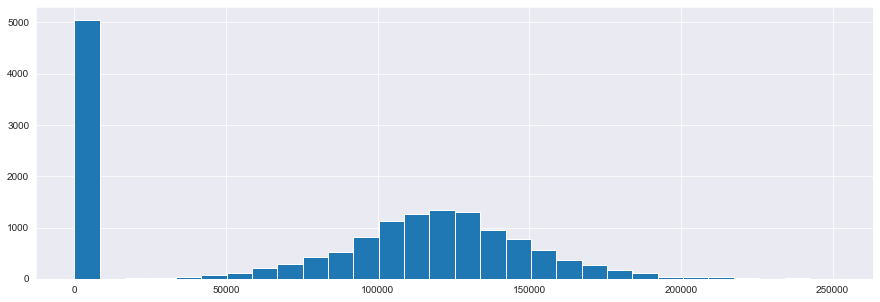

In [39]:
df["Balance"].hist(bins=30, figsize=(15,5))
plt.show()

Distribution selon l'age :

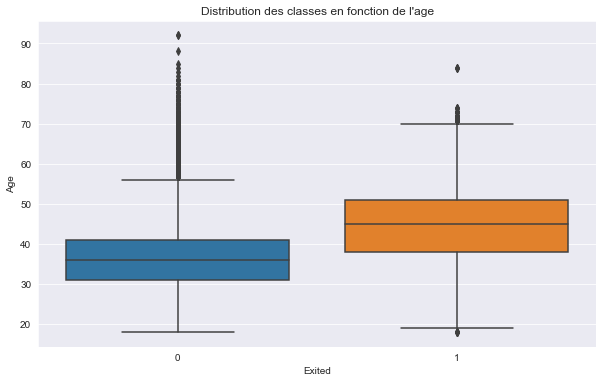

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Exited', y='Age', data=df)
plt.title("Distribution des classes en fonction de l'age")
plt.show()

Distribution de l'age des clients : 

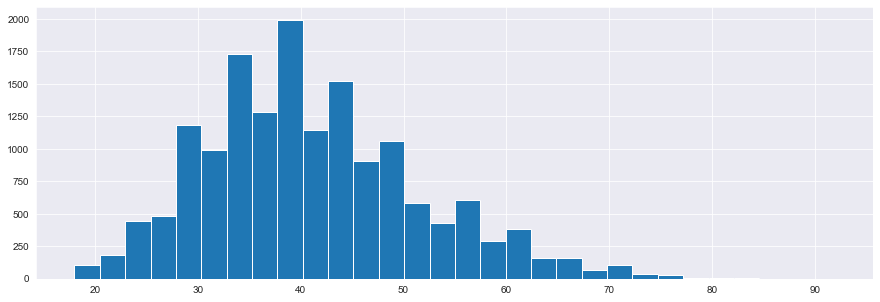

In [41]:
df["Age"].hist(bins=30, figsize=(15,5))
plt.show()

### Variables discretes : 

Voyons par exemples la distribution des clients qui ont une credit card ou non qui reste ou quitte :

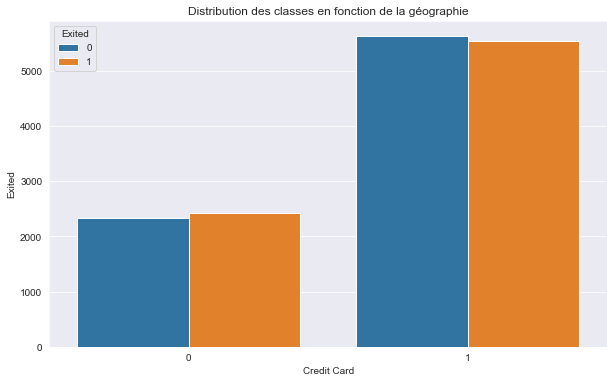

In [42]:
plt.figure(figsize=(10, 6))
sns.countplot(x='HasCrCard', hue='Exited', data=df)
plt.title('Distribution des classes en fonction de la géographie')
plt.xlabel('Credit Card')
plt.ylabel('Exited')
plt.show()

 ## 3. Preparation des données à utiliser par le modèle : 

On scale nos données : 

In [43]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = [col for col in df.columns if col != 'Exited']

data_to_scale = df[columns_to_scale]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
scaled_df['Exited'] = df['Exited'] 

Divisant nos données en train et test : 80% pour le train et 20% pour le test : 

In [44]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(scaled_df, test_size=0.2, random_state=42)

Mettons nos données au même échelle puisqu'il y a une grande difference d'echelle entre eux : 

In [45]:
train_df.head()

,Geography_France,Geography_Germany,Geography_Spain,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
13555,0.0,1.0,0.0,0.882,0.0,0.324324,1.0,0.453002,0.333333,0.0,1.0,0.699742,1
1665,1.0,0.0,0.0,0.798,1.0,0.324324,0.1,0.517249,0.333333,0.0,1.0,0.717703,0
14878,1.0,0.0,0.0,0.698,1.0,0.297297,0.7,0.000000,0.000000,0.0,1.0,0.764396,1
7471,0.0,1.0,0.0,0.616,0.0,0.500000,0.8,0.475603,0.000000,0.0,1.0,0.597197,0
2582,1.0,0.0,0.0,0.612,0.0,0.378378,0.5,0.451985,0.333333,1.0,1.0,0.694254,0


In [46]:
train_df = train_df.rename(columns = {"Exited" : "label"})
test_df =  test_df.rename(columns = {"Exited" : "label"})

## 4. Entrainement du modèle : 

Créons maintenant notre modèle en utilisant les fonctions du module "decision_tree_algorithm"

In [47]:
tree = decision_tree_algorithm(train_df, ml_task='classification', max_depth=10)

## 5. Grid Search : 

Cherchons le meilleur max_depth pour notre modèle : 

In [24]:
metrics = {"max_depth": [], "acc_tree": []}
scaled_df = scaled_df.rename(columns = {'Exited' : 'label'})
for n in range(10, 26):
    df_train, df_test = train_test_split(scaled_df, test_size=0.15)
    df_train, df_val = train_test_split(df_train, test_size=0.15)

    tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=n)
    
    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("max_depth")

Voyons maintenant le max_depth qui donne la meilleure accuracy : 

In [25]:
df_metrics.loc[df_metrics['acc_tree'] == df_metrics['acc_tree'].max()]

,acc_tree
max_depth,
21,0.913353


Donc le meilleur max_depth à utiliser est 21

## 6. Entrainement 2 : 

In [27]:
tree = decision_tree_algorithm(train_df, ml_task='classification', max_depth=21)

## 7. Evaluation : 

In [28]:
accuracy = calculate_accuracy(test_df, tree)
print(f"Accuracy de l'arbre de décision: {accuracy:.2f}")

Accuracy de l'arbre de décision: 0.91


In [29]:
def calculate_confusion_matrix(df, tree):
    predictions = make_predictions(df, tree)
    TP = sum((predictions == 1) & (df['label'] == 1))
    TN = sum((predictions == 0) & (df['label'] == 0))
    FP = sum((predictions == 1) & (df['label'] == 0))
    FN = sum((predictions == 0) & (df['label'] == 1))
    return np.array([[TP, FP], [FN, TN]])

confusion_matrix = calculate_confusion_matrix(test_df, tree)

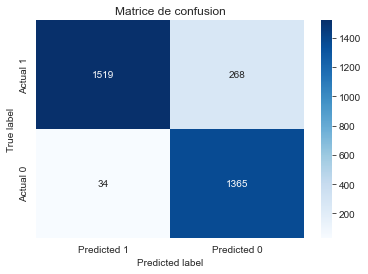

In [30]:
def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', 
                xticklabels=['Predicted 1', 'Predicted 0'], 
                yticklabels=['Actual 1', 'Actual 0'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Matrice de confusion')
    plt.show()

confusion_matrix = calculate_confusion_matrix(test_df, tree)
plot_confusion_matrix(confusion_matrix)

## 8. Prediction : 

In [31]:
indiv = [1,0,0,600,1,40,3,60000,2,1,1,50000]

In [32]:
min_vals = df.min()  
max_vals = df.max() 
indiv = [(x - min_val) / (max_val - min_val) for x, min_val, max_val in zip(indiv, min_vals, max_vals)]

In [33]:
indiv

[1.0,
 0.0,
 0.0,
 0.5,
 1.0,
 0.2972972972972973,
 0.3,
 0.2391409197256145,
 0.3333333333333333,
 1.0,
 1.0,
 0.2499659717503021]

In [34]:
column_names = [
    'Geography_France', 'Geography_Germany', 'Geography_Spain',
    'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance',
    'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'
]

In [35]:
df_indiv = pd.DataFrame([indiv], columns=column_names)

In [36]:
df_indiv.apply(predict_example, args=(tree,), axis=1)

0    0.0
dtype: float64

Donc le client ne va pas quitter la banque 